In [14]:
import git
import pandas as pd
import numpy as np
import os
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import yfinance as yf

In [15]:
# Clone GitHub repository
repo_url = "https://github.com/stihem/DS821"
repo_dir = os.path.join(os.getcwd(), 'DS821-SH')
if not os.path.exists(repo_dir):
    git.Repo.clone_from(repo_url, repo_dir)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Define file paths
data_dir = os.getcwd()
data_file = os.path.join(data_dir, 'reddit_wsb.csv')
ticker_file = os.path.join(data_dir, 'cleaned_stock_tickers.csv')

# Load data
data = pd.read_csv(data_file, parse_dates=['timestamp'], infer_datetime_format=True)
data['text_combined'] = data['title'].fillna('') + ' ' + data['body'].fillna('')
data['post_date'] = pd.to_datetime(data['timestamp']).dt.date

In [17]:
# Filter dataset
start = pd.to_datetime('2021-01-28').date()
end = pd.to_datetime('2021-02-10').date()
data_filtered = data[(data['post_date'] >= start) & (data['post_date'] <= end)]

In [18]:
# Clean text function
def preprocess_text(content):
    content = re.sub(r'@[\w]+', '', content)  # Remove handles
    content = re.sub(r'http\S+', '', content)  # Remove URLs
    content = re.sub(r'[^a-zA-Z0-9\s]', '', content)  # Remove special characters
    content = re.sub(r'\b\w\b', '', content)  # Remove single letters
    content = re.sub(r'\s+', ' ', content)  # Remove extra spaces
    return content.strip()

data_filtered['clean_text'] = data_filtered['text_combined'].apply(preprocess_text)

In [19]:
# Load NLP model and process text
language_model = spacy.load("en_core_web_sm")
processed_docs = list(language_model.pipe(data_filtered['clean_text']))

# Load ticker data
ticker_data = pd.read_csv(ticker_file)
tickers = ticker_data['Ticker'].str.upper().tolist()

In [20]:
# Extract stock tickers
def find_tickers(doc):
    return [
        token.text.upper()
        for token in doc
        if (
            token.is_alpha and
            len(token.text) in range(2, 6) and
            token.ent_type_ == 'ORG' and
            token.text.upper() in tickers
        )
    ]
data_filtered['extracted_tickers'] = [find_tickers(doc) for doc in processed_docs]

# Count mentions
def ticker_counter(ticker_list):
    ticker_flat = [ticker for sublist in ticker_list for ticker in set(sublist)]
    return dict(Counter(ticker_flat))

mention_count = ticker_counter(data_filtered['extracted_tickers'])
mention_df = pd.DataFrame.from_dict(mention_count, orient='index', columns=['mentions']).reset_index()
mention_df.columns = ['ticker', 'total_mentions']
mention_df = mention_df.sort_values(by='total_mentions', ascending=False)
top_tickers = mention_df.head(3)['ticker'].tolist()

# Explode tickers into rows
expanded_data = data_filtered.explode('extracted_tickers')
expanded_data = expanded_data.rename(columns={'extracted_tickers': 'ticker'})

# Count daily mentions
daily_mentions = expanded_data.groupby(['post_date', 'ticker']).size().reset_index(name='mention_count')

[*********************100%***********************]  1 of 1 completed


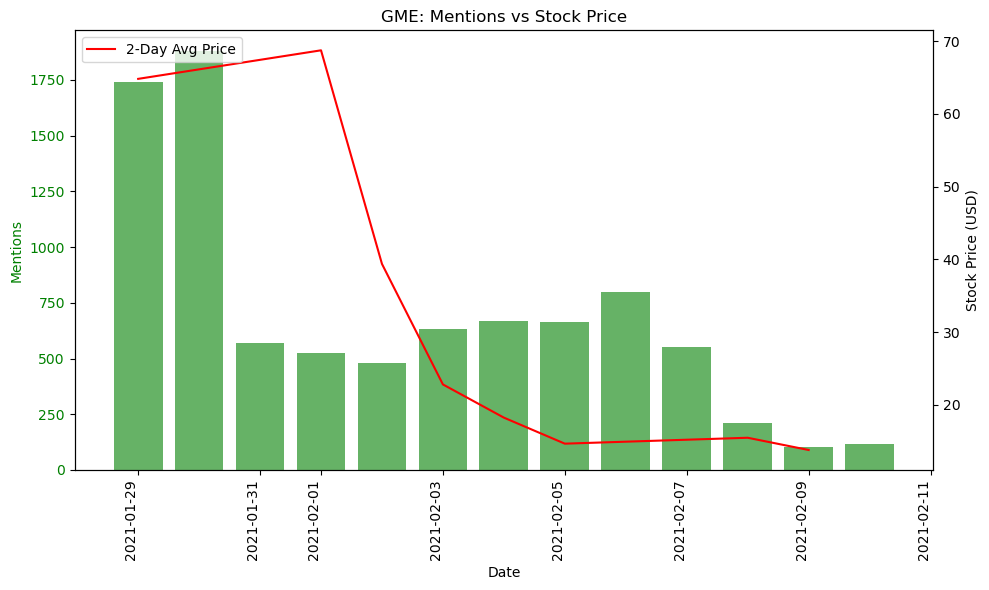

[*********************100%***********************]  1 of 1 completed


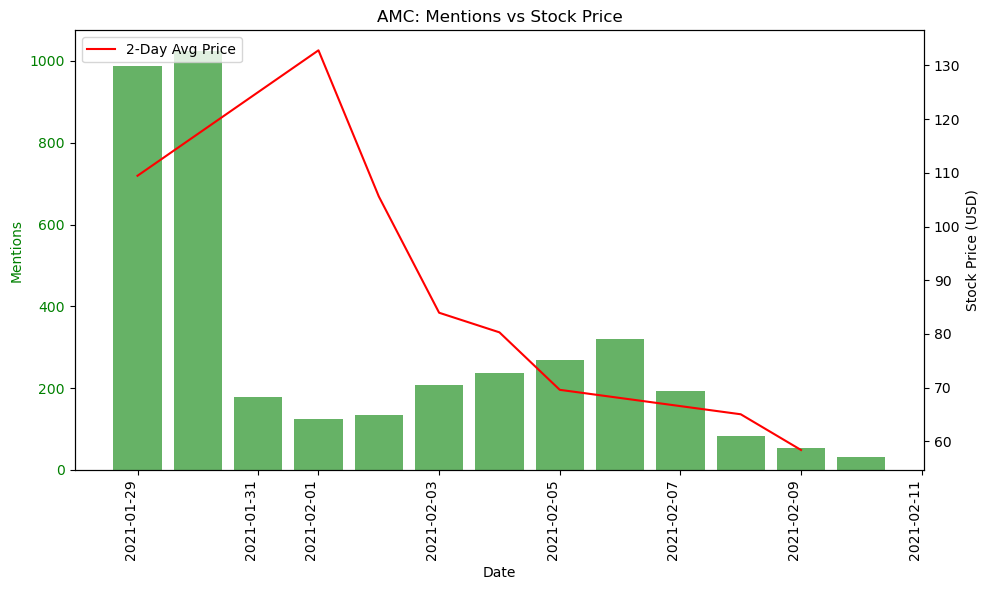

[*********************100%***********************]  1 of 1 completed


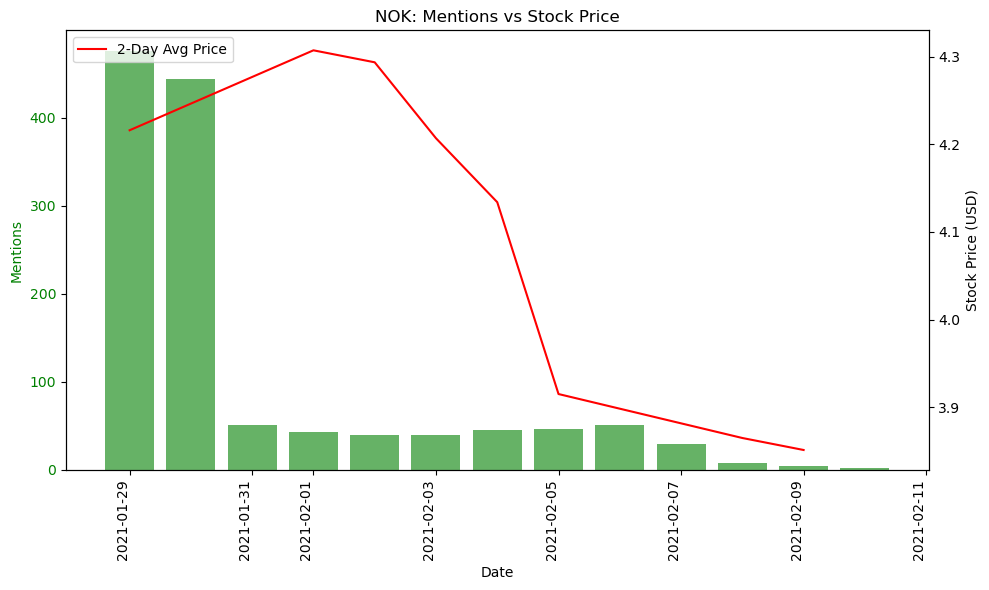

In [30]:
# Plot function
def visualize_ticker_activity(ticker):
    ticker_data = daily_mentions[daily_mentions['ticker'] == ticker]
    ticker_data.set_index('post_date', inplace=True)
    ticker_data['2d_mention_avg'] = ticker_data['mention_count'].rolling(2).mean()

    stock_history = yf.download(ticker, start=ticker_data.index.min(), end=ticker_data.index.max())
    stock_history['2d_price_avg'] = stock_history['Adj Close'].rolling(2).mean()

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(ticker_data.index, ticker_data['2d_mention_avg'], color='green', alpha=0.6, label='2-Day Avg Mentions')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mentions', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot(stock_history.index, stock_history['2d_price_avg'], color='red', label='2-Day Avg Price')
    ax2.set_ylabel('Stock Price (USD)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'{ticker}: Mentions vs Stock Price')

    # Explicitly set x-axis label rotation
    fig.autofmt_xdate(rotation=90)

    fig.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

# Visualize results
for ticker in top_tickers:
    visualize_ticker_activity(ticker)